## The curse of dimensionality

One of the main problems in machine learning is what is known as the curse of dimensionality or the curse of dimensions. This problem arises from the moment in which one tries to improve an approximation by simply using more variables. Maybe you could, but most probably you can't. This is where the curse of dimensionality comes in. It is here that the curse is incurred since, **as the number of characteristics or dimensions increases, the amount of data needed to obtain an accurate generalisation increases exponentially. ** However, before you can tackle the problem, you need to know where it comes from.

![Performance behaviour when the number of variables is increased](./img/unit8/Perfomance_Dimension_plot.png)


### The dimensionality of problems

Rarely do the impact that a given variable will have on an optimisation process come to mind. Take for example a case where there are 5 observations for a given variable **X**, and these observations are uniformly distributed in space. Thus each of the observations will try to represent $\frac{1}{5}$ of the said space.

![](./img/unit8/Sampling_Examples.png)

hen adding another **Y** variable (moving to a two-dimensional space) in order to maintain the same distance between them, i.e. the same rate of representativeness of the space, the number of samples should be increased to 25. With a third one, 125 samples would be needed to explore the space under the same conditions, and so on. 

Therefore, the present problem increases exponentially the more dimensions we have.


### The curse

What happens in a real problem? Well, it is usually not possible to increase the number of samples to maintain the representativeness of the sample points and the equidistance. That is why, if we add a new feature but do not provide enough points, the result would be a more complex model but with an impoverished performance.

The reason for this statement can be clearly seen in the following example in which we try to classify between images of cats and dogs. If only one dimension is taken into account, the examples are uniformly distributed. 

![](./img/unit8/Doom_1.png)

In this case there are 10 samples covering the whole space. But, if you increase one dimension, that distribution becomes something like the following figure.

![](./img/unit8/Doom_2.png)

This situation might lead one to think that a new dimension would make it even easier to divide the space. For example, adding a third dimension to the previous problem would give something like:

![](./img/unit8/Doom_3.png)

Where the result is linearly separable as can be seen in the following image.

![](./img/unit8/Doom_4.png)

The erroneous conclusion that can be drawn is that the higher the dimensionality is increased, the easier the separation on the basis of features will be. Note how the distribution of the data has changed: while in one dimension there are 2 samples per five-sample interval mentioned above, in three-dimensional space there are barely 0.08 samples per interval (10/125). Therefore, it is more complicated to find counter examples on the same side of the classifier. The problem arises when we project this data to a lower dimensional space as happens when any artificial neural network is applied when creating a classifier. In that situation the result would be similar to the following figure:

![](./img/unit8/Doom_5.png)

As can be seen in the following figure, the classifier has been overtrained and therefore the result is not as good as it could be for new instances. For example, see the following figure where a simple linear classifier has been applied on fewer dimensions

![](./img/unit8/Doom_6.png)

### How to avoid the curse?

There is no single rule defining how many features should be used in a regression/classification problem. The number will depend on the amount of training data available, the complexity of the decision boundaries and the type of classifier being used. 

There are mainly two types of approaches in order to reduce dimensionality. These two types are:
* projections 
* transformations

The difference between one and the other is that, while projections operate on the space defined by the input samples itself, transformations try to modify this space in order to find a transition function that allows a suitable and separable representation of the data.
Some of the most common techniques are:

* Principal Component Analysis (PCA) 
* Linear Discriminant Analysis (LDA) 
* Linear Discriminant Analysis (LCD)
* Independent Components Analysis (ICA) 
* Locally linear embedding (LLE) 
* T-distributed Stochastic Stochastic Neighbor Embedding (t-SNE) 
* IsoMaps
* Autoencoders

## Loading the data for the examples
In this unit we are going to load, again, the machine learning problem known as **rock or mine?**. As it was said in the previous unit, this small database consists of 111 patterns corresponding to rocks and 97 patterns corresponding to water mines (simulated as metal cylinders). Each of the patterns consists of 60 numerical measurements between 0.0. and 1.0. These measurements correspond to the energy value of different wavelength ranges for a certain period of time.

The first step will be to download the data set if it is not already available. For this purpose, the following code will be used with the utility function shown below. You should already have it downloaded, but as an alternative to the previous case where we use the DataFrames to prepare the data in this case we are going to use pure default libraries and Arrays

In [14]:
using Downloads;
using DelimitedFiles;
using Statistics;
import Dates;
using Random;

function load_data(filename::String, url::String)
    if !isfile(filename)
        Downloads.download(url, filename)
    end
    data = readdlm(filename,',');
end

file_name = "sonar.all_data"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
data = load_data(file_name, url)
size(data)

(208, 61)

#### Question
Does the fact that the values of the variables are between 0 and 1 imply that they are standardised?

`No. Some values can be in range (0,0.5) for example, and therefore need to be normalised. The only way to make sure that the values are standarised is by performing standarisation or checking the dataset source.`

### Data pre-processing
Once the data have been downloaded, although the measurements are already normalised, although they are not standardised, it is necessary to make a small adaptation to the data. Specifically, it is necessary to divide the set into inputs and outputs, as well as to change the interpretation of the last column, which contains the problem label, to an integer. In addition, the data set will also be divided into training and test. This division will maintain a percentage of 10% of patterns for the test.

In [197]:
function holdOut(N::Int, P::Real)
    @assert ((P >= 0.) & (P <= 1.)) "The percentage must be a number between 0 and 1"
    
    indices = randperm(N)
    sizeTrainSet = Int(round(N * (1 - P)))
    return indices[1:sizeTrainSet], indices[sizeTrainSet + 1:end]
end;

function oneHotEncoding(feature::AbstractArray{<:Any,1}, classes::AbstractArray{<:Any,1})
    nClasses = length(classes)
    println(nClasses)
    if nClasses == 2
        feat = convert(Array{Bool}, feature .== classes[1])  # encode the first class as 1/true and the second class as 0/false
        feat = reshape(feat, (length(feat), 1))  # convert from Vector to Matrix with one column
    else
        # permutedims is necessary because the transpose operation is not defined for e.g. string vectors
        feat = Array{Bool,2}((permutedims(feature) .== classes)')
    end
    return feat
end;

oneHotEncoding(feature::AbstractArray{<:Any,1}) = oneHotEncoding(feature, unique(feature));
oneHotEncoding(feature::AbstractArray{Bool,1}) = oneHotEncoding(reshape(feature, 1, :))

function calculateMinMaxNormalizationParameters(dataset::AbstractArray{<:Real,2})
    return minimum(dataset, dims=1), maximum(dataset, dims=1)
end;

function normalizeMinMax!(dataset::AbstractArray{<:Real,2},      
    normalizationParameters::NTuple{2, AbstractArray{<:Real,2}})
    min, max = normalizationParameters
    dataset .-= min
    dataset ./= (max .- min)
    dataset[:, vec(max .== min)] .= 0  # can be removed the attributes whose max == min in the same variable? (no reassign)
    return dataset
end;

function normalizeMinMax!(dataset::AbstractArray{<:Real,2})
    min, max = calculateMinMaxNormalizationParameters(dataset)
    return normalizeMinMax!(dataset, (min, max))
end;

function normalizeMinMax(dataset::AbstractArray{<:Real,2},      
    normalizationParameters::NTuple{2, AbstractArray{<:Real,2}}) 
    newDataset = copy(dataset)
    normalizeMinMax!(newDataset, normalizationParameters)
    return newDataset
end;

function normalizeMinMax(dataset::AbstractArray{<:Real,2})
    return normalizeMinMax(copy(dataset), calculateMinMaxNormalizationParameters(dataset))
end;

In [198]:
# Prepare input data
input_data = normalizeMinMax!(convert(Array{Float32,2},data[:,1:end-1]))
@assert isa(input_data, Array{<:Float32,2})

# Prepare output data
output_data = oneHotEncoding(data[:, end])
println(typeof(output_data))
#@assert isa(output_data, AbstractArray{Bool,2})

# Split the data in train and test dataset
ho_train, ho_test = holdOut(size(input_data,1), 0.1)
train_input, train_output = input_data[ho_train, :], output_data[ho_train, :]
test_input, test_output = input_data[ho_test, :], output_data[ho_test, :]

println(size(train_input), size(train_output), size(test_input), size(test_output))

print(isa(output_data, AbstractArray{Bool,2}))

# @assert size(train_input) ≈ [floor(Int, 0.9*length(input_data)), size(input_data)[2]]

2
Matrix{Bool}
(187, 60)(187, 1)(21, 60)(21, 1)
true

## Principal Component Analysis (PCA)

Probably the most widely used dimensionality reduction technique. It can be used both individually and in combination with other techniques. It is a method that transforms data by means of a projection onto a set of orthogonal axes. To do this, the method searches for the best linear combinations of the original variables, trying to maximise the variance along the new variable. For example, the image on the right shows a set of points in three dimensions. These three dimensions, when projected, give the images on the right that allow us to see the variability of the data for each of the axes. The continuous line is the one with the highest variability and, therefore, the one that will be taken as the base or first component. For the second component, among the remaining possibilities, the one that maximises and remains perpendicular (orthogonal) to the first dimension selected will be chosen.

![](./img/unit8/PCA.png)

If a third dimension is needed, PCA would have to search for one that is perpendicular to these. This process is based on the so-called *Single Value Decomposition (SVD)* matrix which extracts the eigenvectors from the sample space. These are sorted in decreasing order and those that best represent the corresponding space are selected.

For those who wish to understand in detail how it works, a step-by-step description of how to implement PCA can be found in the following [link](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html).

Generally speaking, if you want to make use of PCA, a good alternative is to use the implementation as found in the `scikit-learn` library. This library has the `PCA` function that allows us to execute this reduction technique. See the following example:

In [135]:
# using ScikitLearn

# @sk_import decomposition:PCA

#Define the PCA object and the number of componentes that are desired
pca = PCA(2)

# print input shape
println("Input shape: ", size(train_input))
println("Input shape: ", size(test_input))
println("Output shape: ", size(train_output))
println("Output shape: ", size(test_output))

#Ajust the matrix acording to the train data
fit!(pca, train_input)

#Once it is ajusted it can be used to transform the data
pca_train = pca.transform(train_input)
pca_test = pca.transform(test_input)

Input shape: (187, 60)
Input shape: (21, 60)
Output shape: (187, 1)
Output shape: (21, 1)


21×2 Matrix{Float32}:
  0.552436    0.128244
  1.0004      0.66115
  0.328975   -1.08027
 -0.992701   -0.468079
  0.696564    1.8506
  0.163164   -0.985136
 -0.696348    0.650667
  0.983936    0.538391
  0.098713    0.813094
 -0.471381   -0.831862
  0.412928   -0.857907
 -0.262869   -0.51469
  0.619834   -0.85295
  0.343062   -0.391497
  0.621755    1.69335
  0.688401    0.737367
  0.511749   -0.578961
  1.08028     0.0233529
  1.05944     1.38274
 -0.0561179  -0.430478
  1.49411    -0.166554

It should be highlighted the importance of fitting the transformation on the training data only. In case of doing it on the total data, the transformation would be contaminating with the transformation the possible training of classification or regression techniques that could be applied later.

One of the main advantages of applying dimensionality reduction is that it allows a first visual study to be carried out by transforming a multidimensional space into a 2 or 3 dimensional space that can be represented graphically. In the example, the PCA-transformed data will be used for the representation. First, a function is defined to facilitate the presentation of the data:

In [199]:
using Plots;

function draw_results(x, y, colors, target_names)
    num_classes = length(unique(colors))
    println("x_shape=", size(x))
    println("y_shape=", size(y))
    if !isnothing(target_names)
        @assert num_classes == length(target_names)
        label = target_names
    else
        label =  [string(i) for i in range(1,num_classes)]

    end
    fig = plot()

    for i in range(1, num_classes)
        scatter!(fig, scatter(x[y[:,1],1], x[y[:,1],2], makercolor=colors[i], label=label[i]))
    end
end

draw_results (generic function with 2 methods)

Without dimensionality reduction, the expert would be responsible for choosing the two variables to represent. Doing so would run the risk of not representing the distribution correctly. Then, print two of the dimensions of your choice and compare the results with the one obtained by PCA.

x_shape=(187, 2)
y_shape=(187, 1)


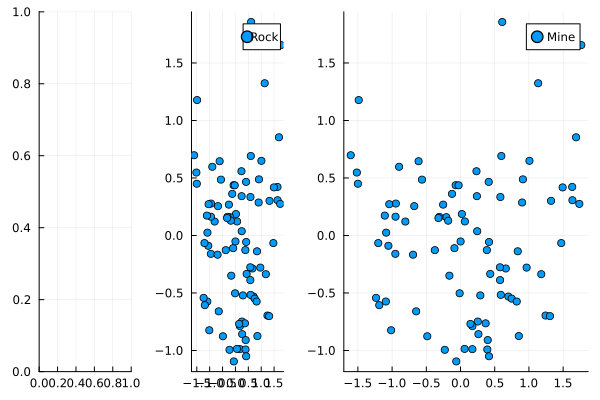

In [209]:
#draw_results(pca_train, train_output, [:green,:red], ["Rock", "Mine"])

x = pca_train
y = train_output
colors = [:green,:red]
target_names = ["Rock", "Mine"]

num_classes = length(unique(colors))
println("x_shape=", size(x))
println("y_shape=", size(y))
if !isnothing(target_names)
    @assert num_classes == length(target_names)
    label = target_names
else
    label =  [string(i) for i in range(1,num_classes)]

end
fig = plot()
for i in range(1, num_classes)
    fig = scatter!(fig, scatter(x[y[:], 1], x[y[:], 2], makercolor=colors[i], label=label[i]))
end

fig

A reduction to 2 or 3 dimensions can be helpful when trying to make a first analysis to, for example, determine whether a linear classifier can give good results or whether there is a pattern in the distribution of the data. However, it is more usual to try to reduce the dimensionality while keeping as much variability as possible. To do this, the scikit-learn function allows you to pass a value between 0 and 1, which determines the percentage of variability that should be maintained. A typical value is 0.95 as it maintains almost all the relevant information and eliminates most of the noise. For example the same examble as before but making a reduction of 95% should be:

In [210]:
pca = PCA(0.95)
fit!(pca, train_input)

#Once it is ajusted it can be used to transform the data
pca_train = pca.transform(train_input)
pca_test = pca.transform(test_input)

print("Train Patterns ", size(train_input), " -> ", size(pca_train))
print("Train Patterns ", size(test_input), " -> ", size(pca_test))

Train Patterns (187, 60) -> (187, 27)Train Patterns (21, 60) -> (21, 27)

Apart from being able to represent the information, reducing the dimensionality is often associated with an acceleration of training. This is because the computational complexity and computational effort of most learning algorithms is conditioned by the number of variables. In addition, there is also often an improvement in the models when some of the noise is removed.

In [211]:
%%timeit
# A continuación veamos unas cuantas aproximaciones básicas y el tiempo que tardan
@sk_import svm:SVC
@sk_import tree:DecisionTreeClassifier
@sk_import linear_model:LogisticRegression, SGDClassifier
@sk_import naive_bayes:GaussianNB 

models = Dict( "SVM" => SVC(probability=true), 
         "LR" =>LogisticRegression(),
         "DT"=> DecisionTreeClassifier(max_depth=4),
         "NB"=> GaussianNB())
base_models = ['SVM', 'LR','DT','NB']

for key in keys(models)
    model = models[key]
    fit!(model,train_input, train_output)
    acc = score(model,test_input, test_output)
    println("$key: $(acc*100) %")
end

The analogue of IPython's `%time statement` (also `%timeit`) in Julia is `@time statement`.  The analogue of `%%time ...code...` is

```
@time begin
    ...code...
end
```

Note, however, that you should put all performance-critical code into a function, avoiding global variables, before doing performance measurements in Julia; see the [performance tips in the Julia manual](http://docs.julialang.org/en/latest/manual/performance-tips/).

The `@time` macro prints the timing results, and returns the value of evaluating the expression.  To instead return the time (in seconds), use `@elapsed statement`.

For more extensive benchmarking tools, including the ability to collect statistics from multiple runs, see the [BenchmarkTools package](https://github.com/JuliaCI/BenchmarkTools.jl).


### Question
Compares the results after applying PCA on the data. To do that, you have to implement the same train process as in the previous piece of code but this time using the PCA. 

In [ ]:
%%timeit

#TODO

Another important parameter within the `PCA` function indicates how the SVD matrix is calculated. The implementation available in `scikit-learn` presents different alternatives, of which two stand out:
1. the first one extracts the eigenvectors based on the `LAPACK` implementation of another well-known package such as `scipy`.
1. In case the dimensions of the matrix are small (less than 500x500) and the number of components to be extracted is less than 80%, it is recommended to use the implementation of the `randomized truncated SVD` algorithm presented in the articles [1, 2].

Additionally, it is also worth mentioning that `scikit-learn` presents some of the most frequent variants of PCA, such as:
* [Kernel Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA), this method transforms the initial space with the application of a kernel in which it is easier to subsequently apply PCA. Unlike PCA, it is not a linear transformation.

* Sparse Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA), an implementation that first searches for a set of sparse features to reconstruct the original set by controlling the degree of diffusion and then applying PCA.

* Dimensionality reduction using truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD), a version that does not centre the data before the SVD calculation and can work with sparse matrices efficiently. 

* Incremental Principal Components Analysis (IPCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA) Batch application of PCA without scaling the data prior to SVD calculation. May be an improvement in memory usage, but due to batching may not be as accurate at times.

[1] Halko, N., Martinsson, P. G., and Tropp, J. A. (2011). "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions". SIAM review, 53(2), 217-288](https://doi.org/10.1137/090771806)

[2] Martinsson, P. G., Rokhlin, V., and Tygert, M. (2011). "A randomized algorithm for the decomposition of matrices". Applied and Computational Harmonic Analysis, 30(1), 47-68](https://doi.org/10.1016/j.acha.2010.02.003)

## Independent Component Analysis (ICA)

Although it is often not referred to as a dimensionality reduction technique, but rather as a principal component extraction technique, it is probably the second most popular technique applied in this sense. ICA is also a linear dimension reduction method, which transforms the dataset into columns of independent components. Blind source separation and the "cocktail party problem" are other names for it. ICA is an important tool in neuroimaging, fMRI and EEG analysis that helps to separate normal signals from abnormal ones.

In the case of this algorithm, it assumes that the data presented are the result of a linear combination of two inputs and that neither of them has a Gaussian distribution. If this condition is not met, the results will not be good or will be inconsistent.

Without going too much into the mathematical underpinnings, it should be noted that problems arising from non-linear dependencies or having a Gaussian distribution can be minimised by the use of entropy in the formulation of the algorithm.
In general terms, the ICA pseudocode can be summarised as follows:
```
Initialise W
X = PCA(X)
While W changes:
      W = average(X*G(WX)) - average(g(WTX))W
      W = orthogonalize(W)
return S = WX
```

Where $W$ is the weights matrix that allows the change to be made to the original data, $G$ is a Gentropy matrix (calculation of the entropy difference between two elements) and $g$ is the derivative of the above function. The `orthogonalize` function refers to the process by which the columns of a matrix become orthogonal. Fortunately a much faster implementation of this process can be found in `scikit-learn` with the function [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html). We will now see how to apply it to the above data:

In [ ]:
@skimport decomposition:FastICA
ica = FastICA(n_components=2)
fit!(ica, train_input)

ica_train = ica.transform(train_input)
ica_test = ica.transform(test_input)

print("Train Patterns ", size(train_input), " -> ", size(ica_train))
print("Train Patterns ", size(test_input), " -> ", size(ica_test))

### Question
Comparing the results of both apporach what can be observed on this ones, which is the one easier to classified. Note in the following section plot the output of ICA approach and compare it with the PCA.

In [ ]:
# Plot the output of the ICA transformation

#TODO

`Answer here`

### Question
Repeat the train of the classifiers and compare the results with the two previous approaches. Compare the results.

In [ ]:
# Repeat the training of previous approaches

#TODO

`Answer here`

## Linear Discriminant Analysis (LDA)

This linear machine learning algorithm is used for multi-class classification, although it is sometimes used as a dimensionality reduction algorithm. Beware of confusing it with Latent Dirichlet Allocation (LDA), which is also a dimensionality reduction technique but only applicable to text documents.

LDA tries to separate (or discriminate) as best as possible the samples of the training dataset by their class value. Specifically, the model tries to find a linear combination of input variables that achieves the maximum separation of samples between classes (centroids or class means) and the minimum separation of samples within each class. Therefore, its major difference with PCA is that LDA takes the output class into account, while PCA is completely agnostic to this fact.

Within the `scikit-learn` library, the implementation of the algorithm allows us to use it to classify or to transform the corresponding data. See the following example:

In [ ]:
@sk_import discriminant_analysis: LinearDiscriminantAnalysis
# Be aware that the number of components when the dimensionality is reduced must be
# n_components <= min(n_classes - 1, n_features))  
lda = LinearDiscriminantAnalysis(n_components=1)
fit!(lda, train_input, train_output)

lda_train = lda.transform(train_input)
lda_test = lda.transform(test_input)

print("Train Patterns ", size(train_input), " -> ", size(lda_train))
print("Train Patterns ", size(test_input), " -> ", size(lda_test))

The most important parameters of the function include:

* `solver{'svd', 'lsqr', 'eigen'}, default='svd'` Indicates which algorithm is used to solve the relation.
 - 'svd': Singular value decomposition which does not compute the covariance matrix and is therefore the one indicated with a large number of features.

 - lsqr: Least squares solution. Method that can use another of the parameters called *shrinkage* or custom covariance calculations.

 - eigen': Eigenvalue decomposition. As with the previous method, in this case the eigenvalues of the matrix are calculated.
* `n_components`, refers to the number of components to be used for dimensionality reduction when applying the `transform` method. Note as a general constraint $n_components <= min(n classes - 1, nfeatures))$

* `store_covariance(default=False)` Marks whether the class-weighted covariance matrix will be calculated for the estimator 'svd'. In the other cases it is always calculated independently of this parameter

* `tol(default=1.0e-4)` Flag the tolerance limit for a feature to be considered significant.

For more details, please check the documentation on the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) page.

## t-Distributed Stochastic Stochastic Neighbor Embedding (t-SNE)

It is one of the NON-linear techniques that are focused on dimensionality reduction. It is usually reserved for high dimensionality problems. While PCA is a linear technique that seeks to maximise variance while preserving large pairwise distances (in other words, things that are different end up being far apart), t-SNE is statistically based and tries to overcome shortcomings of other techniques when it comes to exploring data that have a non-linear structure.

![Comparison of distributions](./img/unit8/t-SNE.png) 

The algorithm starts by calculating the probability of similarity of the points in the high-dimensional space (Gaussian function) and calculating the probability of similarity of the points in the low-dimensional space (based on a Cauchy function). The similarity is calculated as the conditional probability that a point $A$ chooses point $B$ as a neighbour if the neighbours are chosen in proportion to their probability density under a Gaussian (normal distribution) centred on $A$. The difference between these conditional probabilities in the higher and lower dimensional space is then minimised for a representation of the data points in the lower dimensional space. To measure the minimisation of the sum of the conditional probability difference, t-SNE minimises the sum of the **Kullback-Leibler divergence** of the global data points using a gradient descent method. This asymmetric statistical function also used in *Generative Adversarial Networks(GAN)* or *Variational Auto Encoders(VAE)* allows optimisation of the distance between probabilistic distributions. 

In general terms, t-SNE attempts to minimise the divergence between two distributions, the first, a distribution that measures the pairwise similarities of the input objects, and the second, a distribution that measures the pairwise similarities of the corresponding points in the low-dimensional space.

One point to note is that as a simplification of the Cauchy distribution, it is usually simplified to a single degree of freedom resulting in a t-student distribution, hence the name of the transformation.

The other point to note is that, after this process, the input features are no longer identifiable, and no inference can be made based solely on the t-SNE result. Hence, it is primarily a data exploration and visualisation technique.


To employ it, use can be made of the corresponding `scikit-learn` library.

In [ ]:
@sk_import manifold:TSNE

tsne = TSNE(n_components=2)
tsne_train = tsne.fit_transform(train_input) 
tsne_test = tsne.fit_transform(test_input)

print("Train Patterns ", size(train_input), " -> ", size(tsne_train))
print("Train Patterns ", size(test_input), " -> ", size(tsne_test))

One of the striking features of the above code is that, as the transformation of t-SNE cannot be stored because it is unsupervised, it cannot be subsequently applied to another set. Furthermore, as they are only graphically meaningful and cannot/should not be used as input to a training method, there is no `transform` function call.

It should be noted that, regarding the use of the t-SNE implementation, it is recommended that for use with high dimensionality (>50) or fuzzy (*sparse*) spaces, another type of dimensionality reduction technique, such as PCA, should be applied beforehand. Subsequently, t-SNE would be applied on the result of this dimensionality reduction technique. 

Among the most important parameters that can be passed to t-SNE are the following:

* `n_components (default: 2)`: Dimensions to which you want to compress the result.
* `perplexity (default: 30)`: this parameter is related to the neighbourhood used by the algorithm partitions. Typical values are in the range $[5,50]$.
* `early_exaggeration (default: 12.0)`: Controls how tight the classes are in the reduction space and, therefore, the expected gap between them.
* `learning_rate (default: 200.0)`: as the name suggests, this is the training parameter that controls learning by gradient descent. Generally speaking, a value in the range $[10.0, 1000.0]$ is usually used.
* `n_iter (default: 1000)`: Maximum number of iterations applied to the optimisation algorithm. The library documentation recommends a number equal to or greater than 250.
* `method (default: 'barnes_hut')`: The method to be applied. By default the Barnes-Hut approximation is used as it has a computational cost of $O(N log(N))$. Alternatively, although slower as it has a complexity of $O(N^2)$, the 'exact' method can be used which as the name suggests makes no assumptions or approximations but is the exact value.